### Save entire heart beat as 1D signal (Not using this now)

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb

In [2]:
ROOT_DIR = os.path.abspath("../")
DATA_PATH = os.path.join(ROOT_DIR, "datasets", "mit-bih-arrhythmia-database-1.0.0/")
DATA_PATH

'/home/hasib/hasib/ecg-heart/datasets/mit-bih-arrhythmia-database-1.0.0/'

In [3]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [4]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [5]:
num_sec = 3
fs = 360

def load_ecg(file):
    
    # Load the ECG
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    record = wfdb.rdrecord(file)
    # Load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # Extract the signal
    p_signal = record.p_signal
    
    # Verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # Extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample


def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = DATA_PATH + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [6]:
import random
random.seed(42)
pts_train = random.sample(pts, 28)

pts_dev = [pt for pt in pts if pt not in pts_train]

pts_val = random.sample(pts_dev, 10)
pts_test = [pt for pt in pts_dev if pt not in pts_val]

print(len(pts_train), len(pts_val), len(pts_test))

28 10 10


In [7]:
pts_train

['222',
 '107',
 '101',
 '118',
 '116',
 '115',
 '108',
 '106',
 '214',
 '105',
 '219',
 '205',
 '102',
 '232',
 '220',
 '114',
 '228',
 '117',
 '121',
 '100',
 '231',
 '234',
 '124',
 '122',
 '202',
 '217',
 '212',
 '233']

In [8]:
pts_val

['210', '223', '200', '103', '113', '207', '119', '213', '112', '109']

In [9]:
pts_test

['104', '111', '123', '201', '203', '208', '209', '215', '221', '230']

In [10]:
# Check for overlap
def lists_overlap(a, b):
    for i in a:
        if i in b:
            return True
        return False

In [11]:
lists_overlap(pts_train, pts_test)

False

In [12]:
x_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
x_val, y_val, sym_val = make_dataset(pts_val, num_sec, fs, abnormal)
x_test, y_test, sym_test = make_dataset(pts_test, num_sec, fs, abnormal)

In [13]:
print(x_train.shape, y_train.shape, len(sym_train))
print(x_val.shape, y_val.shape, len(sym_val))
print(x_test.shape, y_test.shape, len(sym_test))

(60560, 2160) (60560, 1) 60560
(23821, 2160) (23821, 1) 23821
(24718, 2160) (24718, 1) 24718


In [14]:
np.savez(os.path.join(ROOT_DIR, "datasets", "train_1D.npz"), 
         name1=x_train, name2=y_train, name3=sym_train)

np.savez(os.path.join(ROOT_DIR, "datasets", "val_1D.npz"), 
         name1=x_val, name2=y_val, name3=sym_val)

np.savez(os.path.join(ROOT_DIR, "datasets", "test_1D.npz"), 
         name1=x_test, name2=y_test, name3=sym_test)

Sanity check

In [15]:
# Load data
data = np.load(os.path.join(ROOT_DIR, "datasets", "train_1D.npz"))
x = data['name1']
y = data['name2']
sym = data['name3']

x.shape, y.shape, sym.shape

((60560, 2160), (60560, 1), (60560,))

In [16]:
x[0]

array([-0.11 , -0.11 , -0.105, ..., -0.015, -0.01 , -0.02 ])

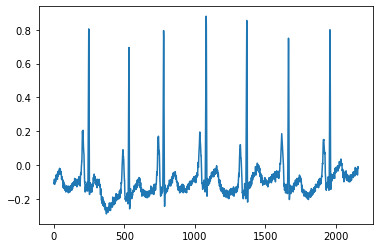

In [17]:
plt.plot(x[0])

In [18]:
y[0]

array([0.])